In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import scipy.stats
from tqdm import tqdm
from ML_components import load_params
from Network import NeuralNetwork

In [2]:
print('Yo, welcome to Main CS')

Yo, welcome to Main CS


## Automatic Tests

In [3]:
symbol_set = [7, 5, 3, 1, -1, -3, -5, -7] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)

decisions = CS.transmission(noise_level=1, mode='euclidean')
CS.evaluate(decisions)

(48, 0.0048)

### Manual Test

In [4]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, 0, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)

# Decision-making using new_values
decisions = CS.decision_making(downsampled/gain_factor, False)

CS.evaluate(decisions)

(0, 0.0)

## Display filter

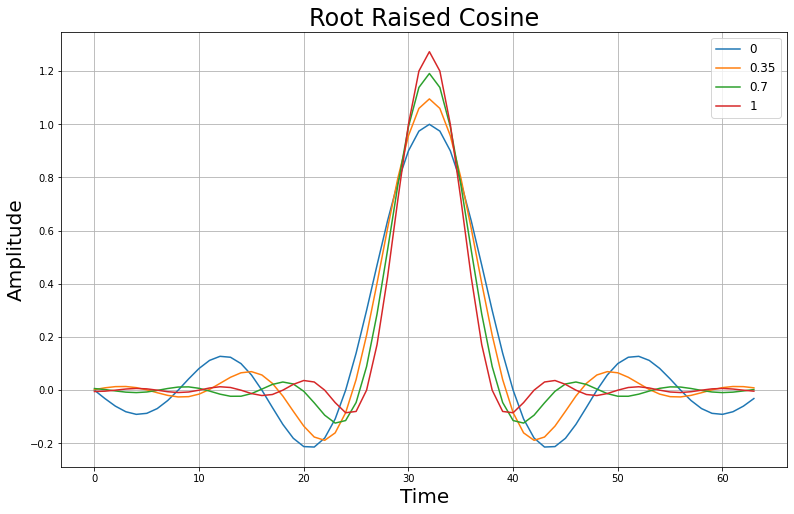

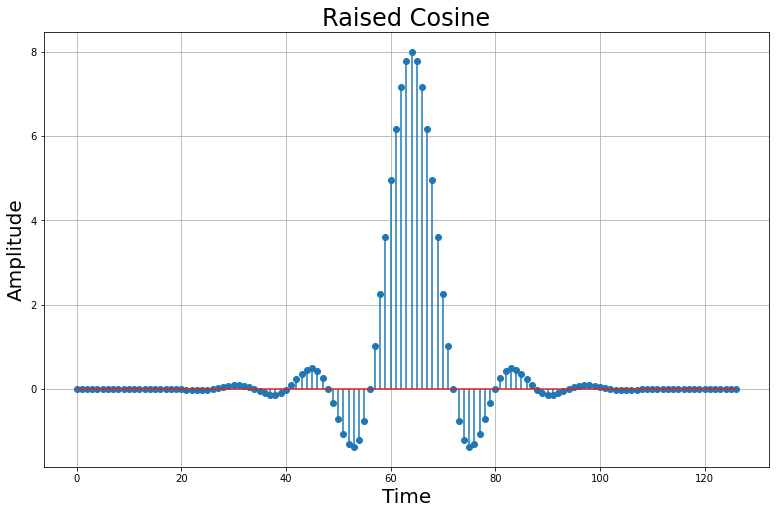

In [5]:
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    #f = np.fft.fft(CS.h)
    plt.plot(CS.h)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
plt.stem(np.convolve(CS.h, CS.h))
plt.grid(True)
plt.show()

____

# Evaluation of pretrained Decision Making models

In [10]:
for i in range(5):
    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 10000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    noise_level = 1

    # Automatic test
    euclid_decisions, NN_decisions, block_decisions, filter_decisions, _ = CS.test_CS(noise_level=noise_level)
    print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(euclid_decisions)[1]*100).round(2)))
    #print('NN Decision Making Error Rate: {}%'.format((CS.evaluate(NN_decisions)[1]*100).round(2)))
    #print('NN Block Error Rate: {}%'.format((CS.evaluate(block_decisions)[1]*100).round(2)))
    print('NN Filter Error Rate: {}%'.format((CS.evaluate(filter_decisions)[1]*100).round(2)))
    print()

Euclidean Distance Error Rate: 0.39%
NN Filter Error Rate: 0.53%

Euclidean Distance Error Rate: 0.28%
NN Filter Error Rate: 0.58%

Euclidean Distance Error Rate: 0.36%
NN Filter Error Rate: 0.58%

Euclidean Distance Error Rate: 0.45%
NN Filter Error Rate: 0.66%

Euclidean Distance Error Rate: 0.38%
NN Filter Error Rate: 0.52%



### SNR Calculations

In [7]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

sigmas = np.linspace(0.75, 4.5, 300) #sigmas = np.linspace(2.5, 4.5, 500)#
SNRs = []
euclid_error_rates = []
error_rates_NN = []
error_rates_NN_blocks = []
error_rates_NN_filter = []
avg_symbol_energy = np.mean(np.array(symbol_seq)**2)
gain_factor = np.max(np.convolve(CS.h, CS.h))

for sigma in sigmas:

    euclid_decisions, NN_decisions, block_decisions, filter_decisions, _ = CS.test_CS(noise_level=sigma)
    SNRs.append(avg_symbol_energy*gain_factor/(sigma**2))
    euclid_error_rates.append(CS.evaluate(euclid_decisions)[1])
    error_rates_NN.append(CS.evaluate(NN_decisions)[1])
    error_rates_NN_blocks.append(CS.evaluate(block_decisions)[1])
    error_rates_NN_filter.append(CS.evaluate(filter_decisions)[1])
    
    
SNRsDB = 10*np.log10(SNRs)
euclid_error_rates = np.array(euclid_error_rates)
error_rates_NN = np.array(error_rates_NN)
error_rates_NN_blocks = np.array(error_rates_NN_blocks)
error_rates_NN_filter = np.array(error_rates_NN_filter)
error_theory = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(gain_factor/sigmas**2))) # 

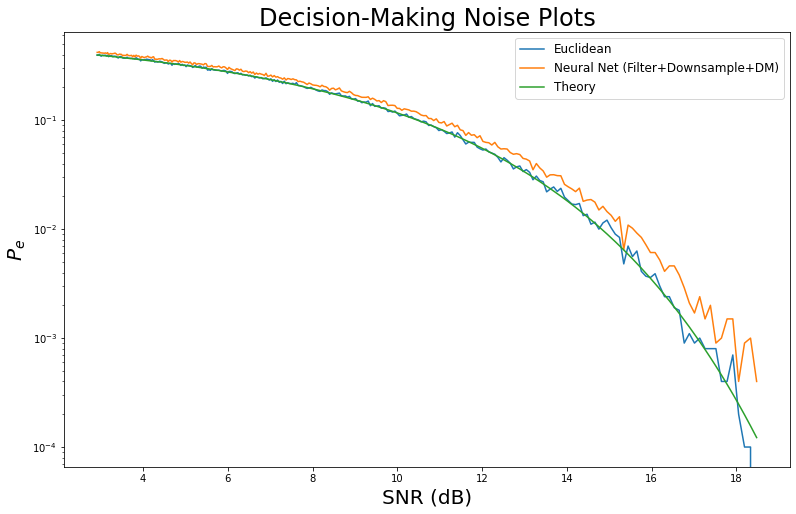

In [14]:
plt.figure(figsize=(13,8))
plt.title('Decision-Making Noise Plots', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRsDB[num:], euclid_error_rates[num:], alpha=1)
#plt.semilogy(SNRsDB[num:], error_rates_NN[num:], alpha=1)
#plt.semilogy(SNRsDB[num:], error_rates_NN_blocks[num:])
plt.semilogy(SNRsDB[num:], error_rates_NN_filter[num:])
plt.semilogy(SNRsDB[num:], error_theory[num:])
legend = ['Euclidean', 'NN', 'NN Blocks', 'NN Filter','Theory']
legend2 = ['Euclidean', 'Neural Net (Filter+Downsample+DM)', 'Theory']
plt.legend(legend2, fontsize=12)
#plt.ylim([1e-3, 1])
plt.show()

# Inspect Decision Boundaries

In [ ]:
weights, biases, sizes = load_params('../Weights/decision_making_weights.npz',
                                         '../Weights/decision_making_biases.npz')
NN = NeuralNetwork(sizes, startweights=weights, startbiases=biases,
                           type='classification', afunc='relu')
classes = np.array(symbol_set)

## Plot 1

In [ ]:
test_seq = np.linspace(-4, 4, 40)
test_seq = np.array(test_seq, ndmin=2).T
yhat_onehot = NN.feedforward(test_seq)


plt.figure(figsize=(13,8))
plt.title('Decision Boundaries', fontsize=24)
for i in range(yhat_onehot.shape[1]):
    plt.plot(test_seq, yhat_onehot[:,i], '-x')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + ['Euclidean Boundaries'], fontsize=14)
plt.show()

## Plot 2

In [ ]:
classes = np.array(symbol_set)
test_seq = np.linspace(-4, 4+1, 100)
test_seq = np.array(test_seq, ndmin=2).T

yhat_idx = NN.feedforward(test_seq).argmax(axis=1)
yhat = classes[yhat_idx]
euclid_decisions = CS.decision_making(test_seq)


num = len(test_seq)
plt.figure(figsize=(13,8))
plt.xlabel('Sample Value (input)', fontsize=20)
plt.ylabel('Decided value (output)', fontsize=20)
plt.plot(test_seq[:num], yhat[:num], '-rx', alpha=0.5)
plt.plot(test_seq[:num], euclid_decisions[:num], '-bx', alpha=1)
plt.legend(['Neural Network', 'Euclidean'], fontsize=14)
plt.show()

##### Want to time something? Use following code stump

In [ ]:
# %%timeit -o -r 5